# Assignment 1: Fine-Grained Bird Classification

## Setup and Configuration

#### Mount Google Drive (If use Colab)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/GitHub_Repos/CS604-CV-Assignments/assignment1/

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from PIL import Image

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score, confusion_matrix

In [2]:
import torch.multiprocessing as mp

mp.set_start_method('spawn', force=True)

### Configuration and Reproducibility Setup

In [42]:
CONFIG = {
    'RANDOM_SEED': 42,
    'IMAGE_SIZE': (224, 224),
    'BATCH_SIZE': 16,
    'EPOCHS': 100,
    'LEARNING_RATE': 0.0005,
    'WEIGHT_DECAY': 5e-4,
    'NUM_CLASSES': 5,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'MODEL_SAVE_PATH': './models/best_bird_cnn.pt',
    'CHECKPOINT_DIR': './models/checkpoints/',
    'EARLY_STOPPING_PATIENCE': 15,
    'SAVE_CHECKPOINTS': True
}

os.makedirs('./models', exist_ok=True)
os.makedirs('./models/checkpoints', exist_ok=True)

print(f"Device: {CONFIG['DEVICE']}")
print(f"Configuration: {CONFIG}")

Device: cuda
Configuration: {'RANDOM_SEED': 42, 'IMAGE_SIZE': (224, 224), 'BATCH_SIZE': 16, 'EPOCHS': 100, 'LEARNING_RATE': 0.0005, 'WEIGHT_DECAY': 0.0005, 'NUM_CLASSES': 5, 'DEVICE': 'cuda', 'MODEL_SAVE_PATH': './models/best_bird_cnn.pt', 'CHECKPOINT_DIR': './models/checkpoints/', 'EARLY_STOPPING_PATIENCE': 15, 'SAVE_CHECKPOINTS': True}


In [43]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(CONFIG['RANDOM_SEED'])

## Data Exploration and Analysis

### Dataset Paths and Config

In [10]:
DATA_ROOT = './CUB_200_2011'
# # kaggle dataset path
# DATA_ROOT = '/kaggle/input/cv-assignment1-dataset/CUB_200_2011'
IMAGES_PATH = os.path.join(DATA_ROOT, 'images')
TRAIN_TEST_SPLIT_PATH = os.path.join(DATA_ROOT, 'train_test_split.txt')
CLASSES_PATH = os.path.join(DATA_ROOT, 'classes.txt')
IMAGE_CLASS_LABELS_PATH = os.path.join(DATA_ROOT, 'image_class_labels.txt')
IMAGES_TXT_PATH = os.path.join(DATA_ROOT, 'images.txt')

In [11]:
TARGET_CLASSES = [
    'Black_footed_Albatross',
    'Red_faced_Cormorant',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_breasted_Chat'
]

### Basic Statistics Analysis

In [12]:
def load_dataset_info():
    images = pd.read_csv(IMAGES_TXT_PATH, sep=' ', header=None, names=['image_id', 'image_name'])
    labels = pd.read_csv(IMAGE_CLASS_LABELS_PATH, sep=' ', header=None, names=['image_id', 'class_id'])
    split = pd.read_csv(TRAIN_TEST_SPLIT_PATH, sep=' ', header=None, names=['image_id', 'is_train'])
    classes = pd.read_csv(CLASSES_PATH, sep=' ', header=None, names=['class_id', 'class_name'])

    return images, labels, split, classes

def parse_class_mapping(classes):
    class_to_id = {}
    id_to_class = {}

    for _, row in classes.iterrows():
        class_id = row['class_id']
        class_name = row['class_name'].split('.')[1]
        class_to_id[class_name] = class_id
        id_to_class[class_id] = class_name

    return class_to_id, id_to_class

def get_target_data(images, labels, split, class_to_id):
    target_ids = [class_to_id[name] for name in TARGET_CLASSES if name in class_to_id]

    data = images.merge(labels, on='image_id').merge(split, on='image_id')
    target_data = data[data['class_id'].isin(target_ids)].copy()

    target_data['class_label'] = target_data['class_id'].map({
        target_ids[i]: i for i in range(len(target_ids))
    })

    return target_data, target_ids

In [13]:
def explore_dataset():
    images, labels, split, classes = load_dataset_info()
    class_to_id, id_to_class = parse_class_mapping(classes)
    target_data, target_ids = get_target_data(images, labels, split, class_to_id)

    print(f"Total images: {len(images)}")
    print(f"Target classes found: {len(target_ids)}")
    print(f"Target images: {len(target_data)}")

    return target_data, class_to_id, id_to_class

In [14]:
def analyze_basic_stats(target_data):
    class_counts = target_data['class_label'].value_counts().sort_index()
    train_counts = target_data[target_data['is_train']==1]['class_label'].value_counts().sort_index()
    test_counts = target_data[target_data['is_train']==0]['class_label'].value_counts().sort_index()

    stats_df = pd.DataFrame({
        'Total': class_counts,
        'Train': train_counts,
        'Test': test_counts
    }).fillna(0).astype(int)

    return stats_df

In [15]:
target_data, class_to_id, id_to_class = explore_dataset()
stats_df = analyze_basic_stats(target_data)

Total images: 11788
Target classes found: 5
Target images: 289


### Data Distribution Analysis and Visualization

In [11]:
def analyze_data_balance(stats_df):
    total_counts = stats_df['Total']
    train_ratios = stats_df['Train'] / stats_df['Total'] * 100

    balance_metrics = {
        'imbalance_ratio': total_counts.max() / total_counts.min(),
        'sample_range': (total_counts.min(), total_counts.max()),
        'mean_train_ratio': train_ratios.mean(),
        'train_ratio_std': train_ratios.std()
    }

    print(f"Imbalance Ratio: {balance_metrics['imbalance_ratio']:.2f}")
    print(f"Sample Range: {balance_metrics['sample_range'][0]} - {balance_metrics['sample_range'][1]}")
    print(f"Train Ratio: {balance_metrics['mean_train_ratio']:.1f}% ± {balance_metrics['train_ratio_std']:.1f}%")

    return balance_metrics

In [12]:
def plot_distribution(stats_df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    class_names = [name.replace('_', ' ') for name in TARGET_CLASSES]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

    bars = axes[0].bar(range(len(class_names)), stats_df['Total'], color=colors)
    axes[0].set_title('Sample Distribution by Class')
    axes[0].set_xticks(range(len(class_names)))
    axes[0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0].set_ylabel('Count')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{int(height)}', ha='center', va='bottom')

    stats_df[['Train', 'Test']].plot(kind='bar', ax=axes[1], color=['lightblue', 'lightcoral'])
    axes[1].set_title('Train/Test Split')
    axes[1].set_ylabel('Count')
    axes[1].set_xticklabels(range(len(class_names)), rotation=0)
    axes[1].legend()

    plt.tight_layout()
    return fig

In [13]:
def distribution_analysis(stats_df):
    print("=== Data Distribution Analysis ===")
    print(stats_df)
    print()

    balance_metrics = analyze_data_balance(stats_df)
    fig = plot_distribution(stats_df)

    plt.show()
    return balance_metrics

=== Data Distribution Analysis ===
             Total  Train  Test
class_label                    
0               60     30    30
1               52     30    22
2               60     30    30
3               58     30    28
4               59     30    29

Imbalance Ratio: 1.15
Sample Range: 52 - 60
Train Ratio: 52.1% ± 3.2%


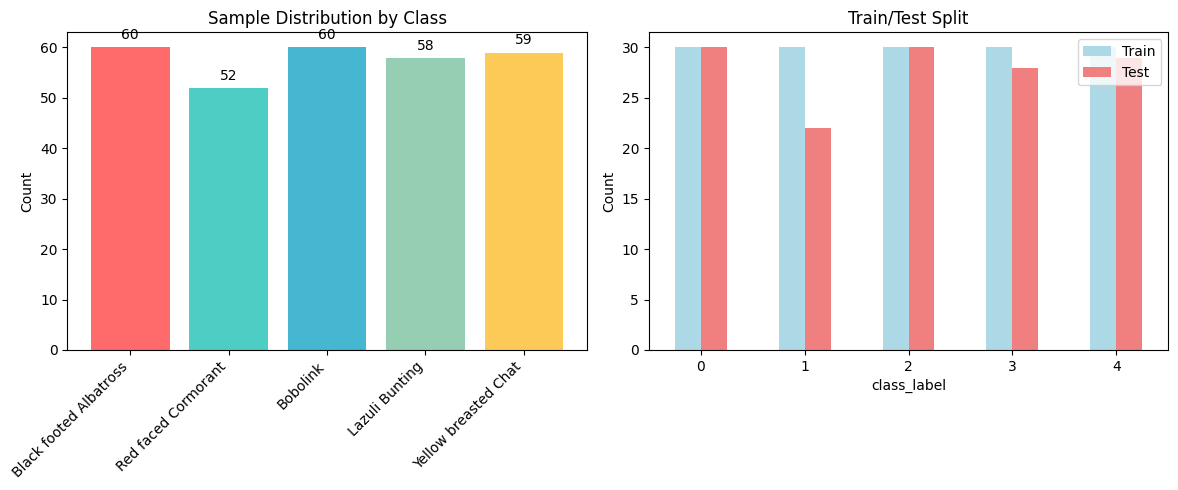

{'imbalance_ratio': 1.1538461538461537,
 'sample_range': (52, 60),
 'mean_train_ratio': 52.05278065009215,
 'train_ratio_std': 3.232371098789766}

In [14]:
balance_metrics = distribution_analysis(stats_df)
balance_metrics

### Image Feature Analysis

In [15]:
def analyze_image_sizes(target_data):
    sizes = []
    aspects = []

    for _, row in target_data.iterrows():
        img_path = os.path.join(IMAGES_PATH, row['image_name'])
        if os.path.exists(img_path):
            img = Image.open(img_path)
            w, h = img.size
            sizes.append((w, h))
            aspects.append(w/h)

    sizes_array = np.array(sizes)
    size_stats = {
        'width_range': (sizes_array[:, 0].min(), sizes_array[:, 0].max()),
        'height_range': (sizes_array[:, 1].min(), sizes_array[:, 1].max()),
        'mean_size': (sizes_array[:, 0].mean(), sizes_array[:, 1].mean()),
        'aspect_ratio_range': (min(aspects), max(aspects)),
        'mean_aspect': np.mean(aspects)
    }

    print(f"Width: {size_stats['width_range'][0]:.0f} - {size_stats['width_range'][1]:.0f}")
    print(f"Height: {size_stats['height_range'][0]:.0f} - {size_stats['height_range'][1]:.0f}")
    print(f"Mean Size: {size_stats['mean_size'][0]:.0f} x {size_stats['mean_size'][1]:.0f}")
    print(f"Aspect Ratio: {size_stats['aspect_ratio_range'][0]:.2f} - {size_stats['aspect_ratio_range'][1]:.2f}")

    return sizes_array, aspects, size_stats

In [16]:
def visualize_samples(target_data):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))

    for class_idx in range(5):
        class_data = target_data[target_data['class_label'] == class_idx].sample(n=5, random_state=42)

        for i, (_, row) in enumerate(class_data.iterrows()):
            img_path = os.path.join(IMAGES_PATH, row['image_name'])
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[class_idx, i].imshow(img)
                axes[class_idx, i].axis('off')
                if i == 0:
                    axes[class_idx, i].set_title(TARGET_CLASSES[class_idx].replace('_', ' '),
                                                fontsize=10, loc='left')

    plt.suptitle('Sample Images per Class (5 samples each)', fontsize=14)
    plt.tight_layout()
    return fig

In [17]:
def analyze_image_quality(target_data):
    brightness_stats = []
    size_variance = []

    for class_idx in range(5):
        class_data = target_data[target_data['class_label'] == class_idx].sample(n=20, random_state=42)
        class_brightness = []
        class_sizes = []

        for _, row in class_data.iterrows():
            img_path = os.path.join(IMAGES_PATH, row['image_name'])
            if os.path.exists(img_path):
                img = np.array(Image.open(img_path))
                if len(img.shape) == 3:
                    brightness = img.mean()
                    class_brightness.append(brightness)
                    class_sizes.append(img.shape[0] * img.shape[1])

        brightness_stats.append(np.mean(class_brightness))
        size_variance.append(np.std(class_sizes))

    quality_stats = pd.DataFrame({
        'Class': TARGET_CLASSES,
        'Mean_Brightness': brightness_stats,
        'Size_Variance': size_variance
    })

    print("Image Quality Analysis:")
    print(quality_stats.round(2))

    return quality_stats

In [18]:
def plot_size_distribution(sizes_array, aspects):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].scatter(sizes_array[:, 0], sizes_array[:, 1], alpha=0.6, s=20)
    axes[0].set_xlabel('Width')
    axes[0].set_ylabel('Height')
    axes[0].set_title('Size Distribution')
    axes[0].axhline(y=224, color='red', linestyle='--', alpha=0.7, label='Target Size')
    axes[0].axvline(x=224, color='red', linestyle='--', alpha=0.7)
    axes[0].legend()

    axes[1].hist(aspects, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1].set_xlabel('Aspect Ratio (W/H)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Aspect Ratio Distribution')
    axes[1].axvline(x=1, color='red', linestyle='--', alpha=0.7, label='Square')
    axes[1].legend()

    widths = sizes_array[:, 0]
    heights = sizes_array[:, 1]
    axes[2].hist([widths, heights], bins=30, alpha=0.7, label=['Width', 'Height'], color=['blue', 'orange'])
    axes[2].set_xlabel('Pixels')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Width/Height Distribution')
    axes[2].axvline(x=224, color='red', linestyle='--', alpha=0.7, label='Target')
    axes[2].legend()

    plt.tight_layout()
    return fig

In [19]:
def image_analysis(target_data):
    print("=== Image Feature Analysis ===")

    sizes_array, aspects, size_stats = analyze_image_sizes(target_data)
    quality_stats = analyze_image_quality(target_data)

    fig1 = visualize_samples(target_data)
    fig2 = plot_size_distribution(sizes_array, aspects)

    plt.show()

    return size_stats, quality_stats, sizes_array, aspects

=== Image Feature Analysis ===
Width: 170 - 500
Height: 136 - 500
Mean Size: 446 x 392
Aspect Ratio: 0.38 - 2.17
Image Quality Analysis:
                    Class  Mean_Brightness  Size_Variance
0  Black_footed_Albatross           143.77       50620.22
1     Red_faced_Cormorant           121.57       54178.89
2                Bobolink           129.52       14591.18
3          Lazuli_Bunting           131.26       35141.09
4    Yellow_breasted_Chat           117.55       16616.63


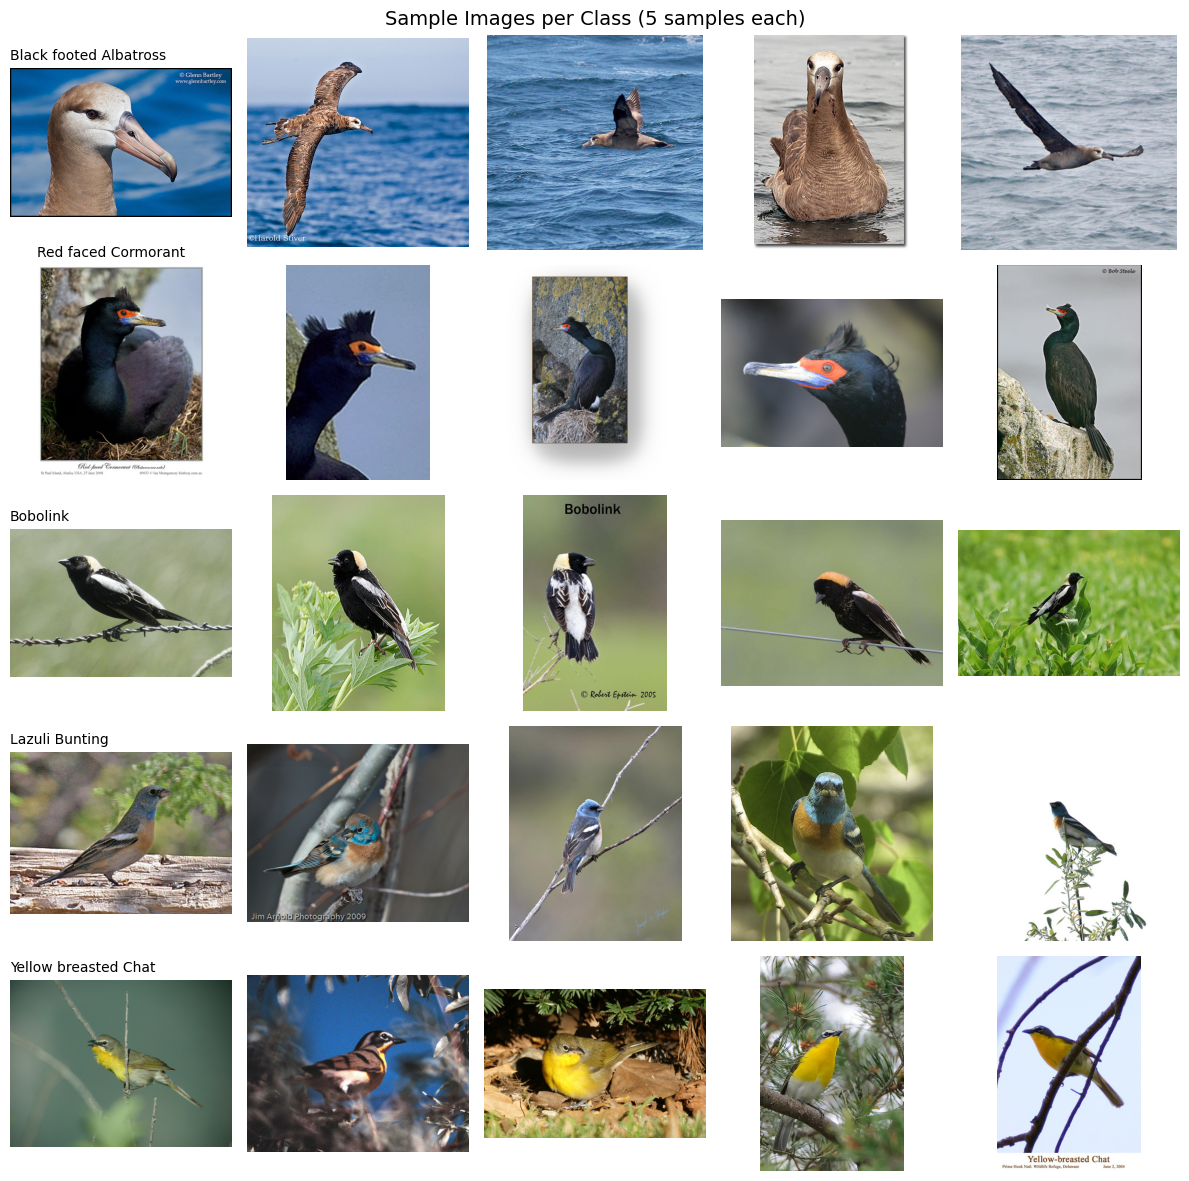

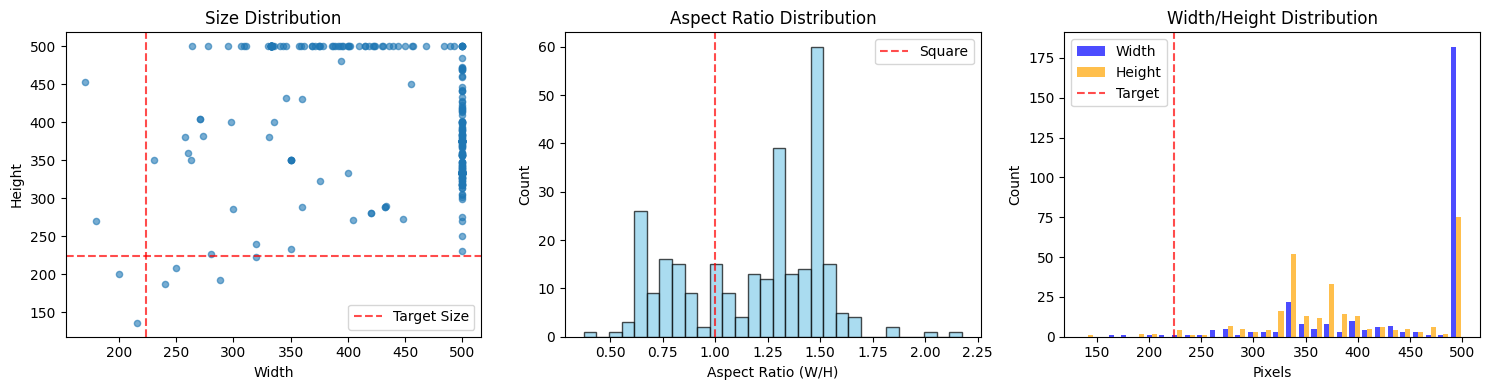

In [20]:
size_stats, quality_stats, sizes_array, aspects = image_analysis(target_data)

### EDA Summary
#### Dataset Balance Analysis

- Excellent class balance: Imbalance ratio of 1.15 (52-60 samples per class) requires no special handling
- Consistent train/test split: Fixed 30 training samples per class, test samples range 22-30
- Stable split ratio: 52.1% ± 3.2% training ratio indicates consistent official splitting strategy

#### Image Characteristics

- Significant size variation: Width ranges 170-500px, height ranges 136-500px
- Large original images: Mean size 446×392px, substantially larger than target 224×224px
- Diverse aspect ratios: Range 0.38-2.17, indicating both tall-narrow and wide-flat images
- Quality differences across classes: Brightness varies 117-143, size variance differs significantly (14,591-54,179)

#### Key Findings

- Red_faced_Cormorant shows highest size variance (54,179) and lowest sample count (52)
- Bobolink demonstrates most consistent image sizes (variance: 14,591)
- Most images exceed target dimensions requiring downsampling
- Aspect ratio distribution centers around 1.0-1.5 (slightly horizontal)

## Data Preprocessing

### Define Image Transforms

In [26]:
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        p_left, p_top = (max_wh - w) // 2, (max_wh - h) // 2
        p_right, p_bottom = max_wh - w - p_left, max_wh - h - p_top
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')

train_transform = transforms.Compose([
    SquarePad(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    SquarePad(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Define Bird Dataset

In [27]:
class BirdDataset(Dataset):
    def __init__(self, target_data, images_path, transform=None, is_train=True):
        if is_train:
            self.data = target_data[target_data['is_train'] == 1].reset_index(drop=True)
        else:
            self.data = target_data[target_data['is_train'] == 0].reset_index(drop=True)

        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.images_path, row['image_name'])

        image = Image.open(img_path).convert('RGB')
        label = row['class_label']

        if self.transform:
            image = self.transform(image)

        return image, label, row['image_name']

In [44]:
generator = torch.Generator()
generator.manual_seed(CONFIG['RANDOM_SEED'])

train_dataset = BirdDataset(target_data, IMAGES_PATH, train_transform, is_train=True)
test_dataset = BirdDataset(target_data, IMAGES_PATH, test_transform, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=0, pin_memory=True, worker_init_fn=seed_worker, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=0, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 150
Test samples: 139


### Preprocessing Validation and Visualization

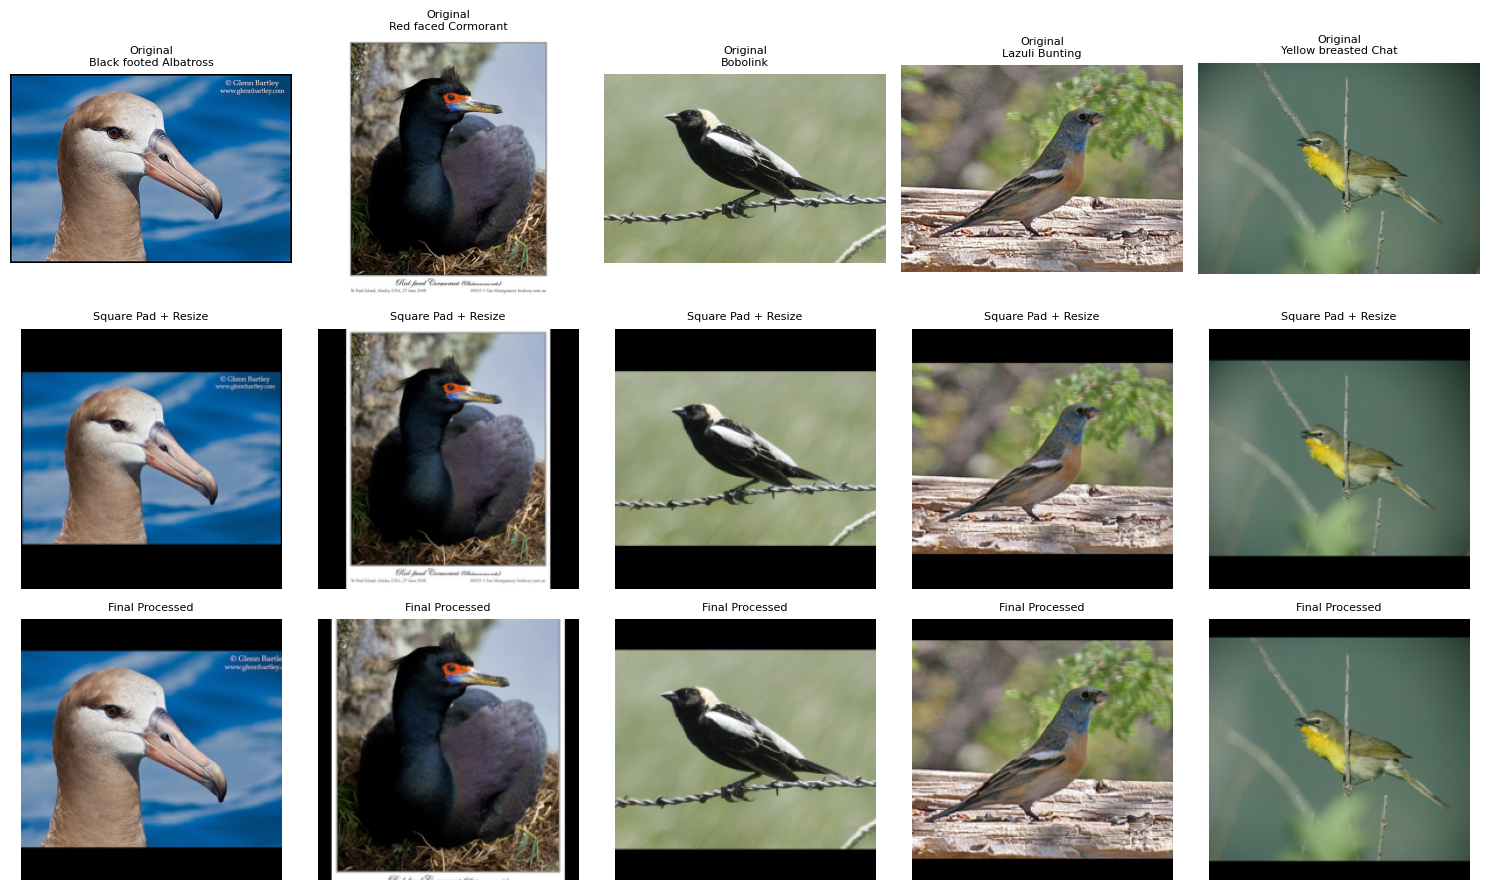

In [24]:
def visualize_preprocessing():
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for class_idx in range(5):
        class_samples = target_data[target_data['class_label'] == class_idx].sample(n=1, random_state=42)
        sample_row = class_samples.iloc[0]
        img_path = os.path.join(IMAGES_PATH, sample_row['image_name'])

        original_img = Image.open(img_path).convert('RGB')

        axes[0, class_idx].imshow(original_img)
        axes[0, class_idx].set_title(f"Original\n{TARGET_CLASSES[class_idx].replace('_', ' ')}", fontsize=8)
        axes[0, class_idx].axis('off')

        square_padded = SquarePad()(original_img)
        resized_only = transforms.Resize((224, 224))(square_padded)
        axes[1, class_idx].imshow(resized_only)
        axes[1, class_idx].set_title("Square Pad + Resize", fontsize=8)
        axes[1, class_idx].axis('off')

        test_processed = test_transform(original_img)
        test_denorm = test_processed * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        test_denorm = torch.clamp(test_denorm, 0, 1)
        axes[2, class_idx].imshow(test_denorm.permute(1, 2, 0))
        axes[2, class_idx].set_title("Final Processed", fontsize=8)
        axes[2, class_idx].axis('off')

    plt.tight_layout()
    return fig

fig = visualize_preprocessing()
plt.show()

### Batch Processing and Statistics

In [25]:
def analyze_processed_data():
    sample_batch = next(iter(train_loader))
    images, labels, _ = sample_batch

    print(f"Batch shape: {images.shape}")
    print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Image mean: {images.mean(dim=[0,2,3])}")
    print(f"Image std: {images.std(dim=[0,2,3])}")

    label_counts = torch.bincount(labels)
    print(f"Labels in batch: {label_counts}")

analyze_processed_data()

Batch shape: torch.Size([16, 3, 224, 224])
Image range: [-2.118, 2.640]
Image mean: tensor([-0.1968,  0.0220,  0.0462])
Image std: tensor([1.3103, 1.3450, 1.3188])
Labels in batch: tensor([6, 2, 4, 2, 2])


## Part 1: CNN for Fine-Grained Bird Classification

### Model Architecture Design

In [29]:
class BirdCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(BirdCNN, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Model Architecture Summary and Visualization

In [45]:
model = BirdCNN(num_classes=5).to(CONFIG['DEVICE'])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)

print(f"Model Parameters: {total_params:,}")
print(f"Device: {CONFIG['DEVICE']}")

dummy_input = torch.randn(1, 3, 224, 224).to(CONFIG['DEVICE'])
with torch.no_grad():
    output = model(dummy_input)
    print(f"Output shape: {output.shape}")

Model Parameters: 7,735,413
Device: cuda
Output shape: torch.Size([1, 5])


### Model Training

#### Training Setup

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=CONFIG['WEIGHT_DECAY'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=CONFIG['EARLY_STOPPING_PATIENCE'])

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc='Training', leave=False)
    for images, labels, _ in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{100*correct/total:.2f}%'})

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

#### Training Loop

In [47]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    set_seed(CONFIG['RANDOM_SEED'])

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_acc = 0.0
    best_model_state = None
    best_epoch = 0
    patience_counter = 0

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch + 1
            patience_counter = 0
        else:
            patience_counter += 1

        if CONFIG['SAVE_CHECKPOINTS'] and (epoch + 1) % 10 == 0:
            checkpoint_path = f"{CONFIG['CHECKPOINT_DIR']}checkpoint_epoch_{epoch+1}.pt"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'scheduler_state_dict': scheduler.state_dict()
            }, checkpoint_path)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Best Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})')
            print(f'LR: {scheduler.get_last_lr()[0]:.6f}')
            print('-' * 50)

        if patience_counter >= CONFIG['EARLY_STOPPING_PATIENCE']:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    torch.save({
        'model_state_dict': best_model_state,
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'config': CONFIG,
        'history': {
            'train_loss': train_losses,
            'train_acc': train_accs,
            'val_loss': val_losses,
            'val_acc': val_accs
        }
    }, CONFIG['MODEL_SAVE_PATH'])
    
    print(f"Best model saved to {CONFIG['MODEL_SAVE_PATH']}")

    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs,
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch
    }

    return model, history

model, history = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, CONFIG['EPOCHS'], CONFIG['DEVICE'])

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/100]
Train Loss: 1.6908, Train Acc: 16.67%
Val Loss: 1.6033, Val Acc: 15.83%
Best Val Acc: 15.83% (Epoch 1)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/100]
Train Loss: 1.3721, Train Acc: 37.33%
Val Loss: 1.3750, Val Acc: 33.09%
Best Val Acc: 34.53% (Epoch 4)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/100]
Train Loss: 1.2094, Train Acc: 43.33%
Val Loss: 1.1767, Val Acc: 53.96%
Best Val Acc: 53.96% (Epoch 10)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/100]
Train Loss: 1.0290, Train Acc: 64.00%
Val Loss: 1.3523, Val Acc: 46.76%
Best Val Acc: 53.96% (Epoch 10)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/100]
Train Loss: 0.5810, Train Acc: 80.67%
Val Loss: 1.0042, Val Acc: 66.91%
Best Val Acc: 67.63% (Epoch 19)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/100]
Train Loss: 0.5219, Train Acc: 83.33%
Val Loss: 0.8156, Val Acc: 76.26%
Best Val Acc: 79.14% (Epoch 22)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30/100]
Train Loss: 0.2603, Train Acc: 90.00%
Val Loss: 0.8264, Val Acc: 73.38%
Best Val Acc: 79.14% (Epoch 22)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [35/100]
Train Loss: 0.6133, Train Acc: 90.00%
Val Loss: 1.0785, Val Acc: 72.66%
Best Val Acc: 81.29% (Epoch 34)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [40/100]
Train Loss: 0.3092, Train Acc: 91.33%
Val Loss: 0.8175, Val Acc: 76.26%
Best Val Acc: 82.73% (Epoch 39)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [45/100]
Train Loss: 0.2787, Train Acc: 93.33%
Val Loss: 0.7851, Val Acc: 74.10%
Best Val Acc: 82.73% (Epoch 39)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [50/100]
Train Loss: 0.1624, Train Acc: 94.00%
Val Loss: 0.5058, Val Acc: 85.61%
Best Val Acc: 85.61% (Epoch 50)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [55/100]
Train Loss: 0.1280, Train Acc: 98.00%
Val Loss: 0.7293, Val Acc: 84.17%
Best Val Acc: 86.33% (Epoch 54)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [60/100]
Train Loss: 0.2042, Train Acc: 95.33%
Val Loss: 0.8437, Val Acc: 82.01%
Best Val Acc: 86.33% (Epoch 54)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [65/100]
Train Loss: 0.1967, Train Acc: 94.67%
Val Loss: 0.8251, Val Acc: 77.70%
Best Val Acc: 86.33% (Epoch 54)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping triggered at epoch 69
Best model saved to ./models/best_bird_cnn.pt


In [29]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    set_seed(CONFIG['RANDOM_SEED'])

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if CONFIG['SAVE_CHECKPOINTS'] and (epoch + 1) % 10 == 0:
            checkpoint_path = f"{CONFIG['CHECKPOINT_DIR']}checkpoint_epoch_{epoch+1}.pt"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'scheduler_state_dict': scheduler.state_dict()
            }, checkpoint_path)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
            print('-' * 50)

        if patience_counter >= CONFIG['EARLY_STOPPING_PATIENCE']:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    model.load_state_dict(best_model_state)

    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs,
        'best_val_acc': best_val_acc
    }

    return model, history

model, history = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, CONFIG['EPOCHS'], CONFIG['DEVICE'])

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/100]
Train Loss: 1.7450, Train Acc: 12.00%
Val Loss: 1.6082, Val Acc: 24.46%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/100]
Train Loss: 1.3071, Train Acc: 46.00%
Val Loss: 1.2302, Val Acc: 48.20%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/100]
Train Loss: 1.0506, Train Acc: 61.33%
Val Loss: 1.3761, Val Acc: 48.92%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/100]
Train Loss: 0.8422, Train Acc: 69.33%
Val Loss: 0.9799, Val Acc: 66.19%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/100]
Train Loss: 0.6529, Train Acc: 74.00%
Val Loss: 0.8662, Val Acc: 69.06%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/100]
Train Loss: 0.5278, Train Acc: 82.67%
Val Loss: 1.0869, Val Acc: 61.87%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30/100]
Train Loss: 0.3620, Train Acc: 88.00%
Val Loss: 0.6021, Val Acc: 78.42%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [35/100]
Train Loss: 0.5019, Train Acc: 88.67%
Val Loss: 0.5696, Val Acc: 79.14%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [40/100]
Train Loss: 0.1820, Train Acc: 94.00%
Val Loss: 0.5371, Val Acc: 83.45%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [45/100]
Train Loss: 0.1827, Train Acc: 93.33%
Val Loss: 0.6258, Val Acc: 79.86%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [50/100]
Train Loss: 0.1482, Train Acc: 93.33%
Val Loss: 0.7854, Val Acc: 77.70%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [55/100]
Train Loss: 0.1015, Train Acc: 96.67%
Val Loss: 0.7295, Val Acc: 82.73%
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping triggered at epoch 56


#### Training Visualization

In [40]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    epochs = range(1, len(history['train_loss']) + 1)

    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    
    return fig

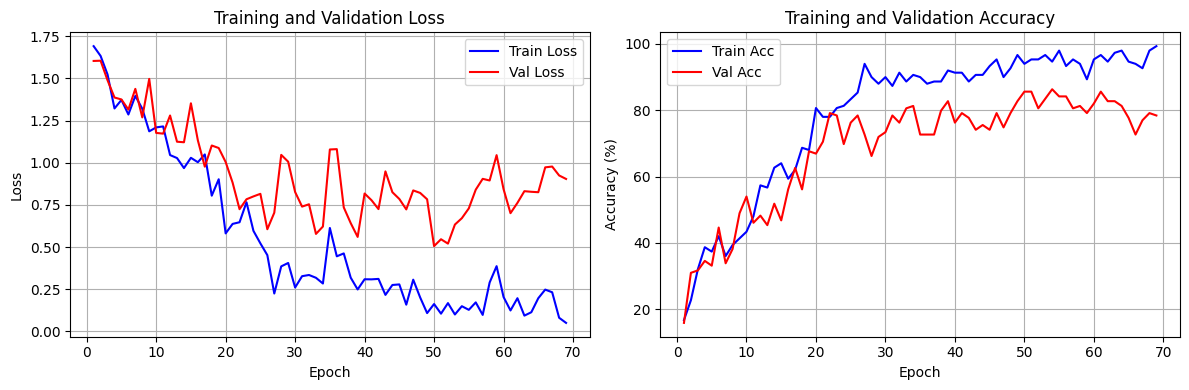

Best Validation Accuracy: 86.33%


In [41]:
fig = plot_training_history(history)
plt.show()

print(f"Best Validation Accuracy: {history['best_val_acc']:.2f}%")

### Model Evaluation and Performance Analysis

In [52]:
checkpoint = torch.load(CONFIG['MODEL_SAVE_PATH'], map_location=CONFIG['DEVICE'])
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(CONFIG['DEVICE'])
model.eval()

history = checkpoint['history']

print(f"Loaded best model with validation accuracy: {checkpoint['best_val_acc']:.2f}%")
print(f"Model loaded on device: {CONFIG['DEVICE']}")

Loaded best model with validation accuracy: 86.33%
Model loaded on device: cuda


In [48]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def calculate_metrics(y_true, y_pred):
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    
    accuracy_per_class = []
    for i in range(len(TARGET_CLASSES)):
        mask = y_true == i
        if mask.sum() > 0:
            acc = (y_pred[mask] == i).sum() / mask.sum()
            accuracy_per_class.append(acc)
        else:
            accuracy_per_class.append(0.0)
    
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    overall_acc = accuracy_score(y_true, y_pred)
    
    metrics_dict = {
        'per_class': {
            'accuracy': accuracy_per_class,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'overall': {
            'accuracy': overall_acc,
            'precision': precision.mean(),
            'recall': recall.mean(),
            'f1': f1.mean(),
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted
        }
    }
    
    return metrics_dict

In [49]:
def create_performance_table(metrics_dict):
    rows = []
    
    for i, class_name in enumerate(TARGET_CLASSES):
        rows.append({
            'Class': class_name,
            'Accuracy': f"{metrics_dict['per_class']['accuracy'][i]*100:.2f}%",
            'Precision': f"{metrics_dict['per_class']['precision'][i]:.4f}",
            'Recall': f"{metrics_dict['per_class']['recall'][i]:.4f}",
            'F1': f"{metrics_dict['per_class']['f1'][i]:.4f}",
            'F1-micro': '-',
            'F1-macro': '-',
            'F1-weighted': '-'
        })
    
    rows.append({
        'Class': 'Overall (Average)',
        'Accuracy': f"{metrics_dict['overall']['accuracy']*100:.2f}%",
        'Precision': f"{metrics_dict['overall']['precision']:.4f}",
        'Recall': f"{metrics_dict['overall']['recall']:.4f}",
        'F1': f"{metrics_dict['overall']['f1']:.4f}",
        'F1-micro': f"{metrics_dict['overall']['f1_micro']:.4f}",
        'F1-macro': f"{metrics_dict['overall']['f1_macro']:.4f}",
        'F1-weighted': f"{metrics_dict['overall']['f1_weighted']:.4f}"
    })
    
    df = pd.DataFrame(rows)
    
    return df

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[name.replace('_', ' ') for name in TARGET_CLASSES],
                yticklabels=[name.replace('_', ' ') for name in TARGET_CLASSES])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    return plt.gcf()

### Performance Results Table

In [50]:
y_true, y_pred, y_probs = evaluate_model(model, test_loader, CONFIG['DEVICE'])

metrics_dict = calculate_metrics(y_true, y_pred)

performance_df = create_performance_table(metrics_dict)
performance_df

Class Accuracy Precision  Recall      F1 F1-micro  \
0  Black_footed_Albatross   73.33%    0.7857  0.7333  0.7586        -   
1     Red_faced_Cormorant   63.64%    0.6667  0.6364  0.6512        -   
2                Bobolink   80.00%    0.6857  0.8000  0.7385        -   
3          Lazuli_Bunting   85.71%    0.9231  0.8571  0.8889        -   
4    Yellow_breasted_Chat   86.21%    0.8621  0.8621  0.8621        -   
5       Overall (Average)   78.42%    0.7846  0.7778  0.7798   0.7842   

  F1-macro F1-weighted  
0        -           -  
1        -           -  
2        -           -  
3        -           -  
4        -           -  
5   0.7798      0.7851

### Confusion Matrix Table

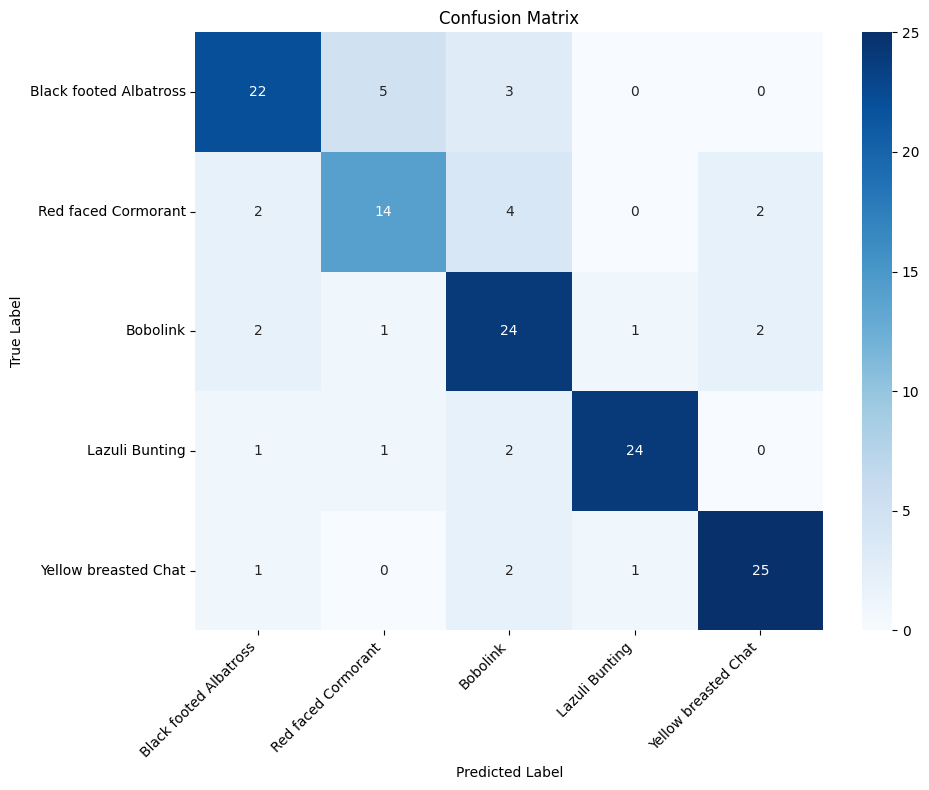

In [51]:
fig_cm = plot_confusion_matrix(y_true, y_pred)
plt.show()

## Part 2: Cost-Sensitive Learning

In [53]:
# Define misclassification cost matrix
COST_MATRIX = np.array([
    [0,  4,  10, 12, 11],  # Albatross
    [3,  0,  11, 13, 12],  # Cormorant
    [9,  10, 0,  2,  3],   # Bobolink
    [13, 12, 2,  0,  4],   # Bunting
    [12, 11, 3,  4,  0]    # Chat
])

### Cost-Sensitive Training Configuration

In [54]:
COST_CONFIG = {
    'RANDOM_SEED': 42,
    'LEARNING_RATE': 0.0005,
    'EPOCHS': 100,
    'ALPHA': 0.7,
    'MODEL_SAVE_PATH': './models/best_cost_sensitive_model.pt',
    'CHECKPOINT_DIR': './models/cost_checkpoints/',
    'EARLY_STOPPING_PATIENCE': 15,
    'WEIGHT_DECAY': 5e-4,
    'SAVE_CHECKPOINTS': True
}

os.makedirs('./models/cost_checkpoints', exist_ok=True)
set_seed(COST_CONFIG['RANDOM_SEED'])

In [97]:
generator = torch.Generator()
generator.manual_seed(CONFIG['RANDOM_SEED'])

train_dataset = BirdDataset(target_data, IMAGES_PATH, train_transform, is_train=True)
test_dataset = BirdDataset(target_data, IMAGES_PATH, test_transform, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=0, pin_memory=True, worker_init_fn=seed_worker, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=0, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 150
Test samples: 139


### Cost evaluation functions

In [55]:
def calculate_misclassification_cost(y_true, y_pred, cost_matrix):
    total_cost = 0
    for true_label, pred_label in zip(y_true, y_pred):
        total_cost += cost_matrix[true_label, pred_label]
    avg_cost = total_cost / len(y_true)
    return avg_cost

def evaluate_with_cost(model, test_loader, cost_matrix, device):
    y_true, y_pred, _ = evaluate_model(model, test_loader, device)
    avg_cost = calculate_misclassification_cost(y_true, y_pred, cost_matrix)
    return avg_cost, y_true, y_pred

In [56]:
def calculate_class_weights_from_cost(cost_matrix):
    avg_costs = cost_matrix.mean(axis=1)
    weights = avg_costs / avg_costs.min()
    return weights

class_weights = calculate_class_weights_from_cost(COST_MATRIX)
class_weights_tensor = torch.FloatTensor(class_weights).to(CONFIG['DEVICE'])

print("Class Weights based on Cost Matrix:")
for i, name in enumerate(TARGET_CLASSES):
    print(f"{name}: {class_weights[i]:.2f}")

Class Weights based on Cost Matrix:
Black_footed_Albatross: 1.54
Red_faced_Cormorant: 1.62
Bobolink: 1.00
Lazuli_Bunting: 1.29
Yellow_breasted_Chat: 1.25


### Cost-Sensitive Training Functions

In [57]:
def train_epoch_cost(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    train_bar = tqdm(train_loader, desc='Training', leave=False)
    for images, labels, _ in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

def validate_epoch_cost(model, val_loader, criterion, cost_matrix, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    avg_cost = calculate_misclassification_cost(np.array(all_labels), np.array(all_preds), cost_matrix)
    
    return epoch_loss, avg_cost

def train_cost_sensitive_model(model, train_loader, test_loader, criterion, optimizer, scheduler, cost_matrix, num_epochs, device, config):
    set_seed(config['RANDOM_SEED'])
    
    train_losses = []
    val_losses = []
    val_costs = []
    
    best_val_cost = float('inf')
    best_model_state = None
    best_epoch = 0
    patience_counter = 0
    
    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        train_loss = train_epoch_cost(model, train_loader, criterion, optimizer, device)
        val_loss, val_cost = validate_epoch_cost(model, test_loader, criterion, cost_matrix, device)
        
        scheduler.step()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_costs.append(val_cost)
        
        if val_cost < best_val_cost:
            best_val_cost = val_cost
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch + 1
            patience_counter = 0
        else:
            patience_counter += 1
        
        if config['SAVE_CHECKPOINTS'] and (epoch + 1) % 10 == 0:
            checkpoint_path = f"{config['CHECKPOINT_DIR']}checkpoint_epoch_{epoch+1}.pt"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_cost': val_cost,
                'scheduler_state_dict': scheduler.state_dict()
            }, checkpoint_path)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Hybrid Loss: {train_loss:.4f}')
            print(f'Val Hybrid Loss: {val_loss:.4f}')
            print(f'Val Misclassification Cost: {val_cost:.4f}')
            print(f'Best Val Cost: {best_val_cost:.4f} (Epoch {best_epoch})')
            print(f'LR: {scheduler.get_last_lr()[0]:.6f}')
            print('-' * 50)
        
        if patience_counter >= config['EARLY_STOPPING_PATIENCE']:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    torch.save({
        'model_state_dict': best_model_state,
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_cost': best_val_cost,
        'best_epoch': best_epoch,
        'config': config,
        'cost_matrix': cost_matrix.tolist(),
        'history': {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'val_cost': val_costs
        }
    }, config['MODEL_SAVE_PATH'])
    
    print(f"Best model saved to {config['MODEL_SAVE_PATH']}")
    
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_cost': val_costs,
        'best_val_cost': best_val_cost,
        'best_epoch': best_epoch
    }
    
    return model, history

### Custom loss function

In [58]:
class HybridCostLoss(nn.Module):
    def __init__(self, cost_matrix, class_weights, device, alpha=0.7):
        super(HybridCostLoss, self).__init__()
        self.cost_matrix = torch.FloatTensor(cost_matrix).to(device)
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        self.alpha = alpha
    
    def forward(self, outputs, targets):
        ce = self.ce_loss(outputs, targets)
        
        probs = torch.softmax(outputs, dim=1)
        costs = self.cost_matrix[targets]
        expected_cost = (probs * costs).sum(dim=1).mean()
        
        total_loss = self.alpha * ce + (1 - self.alpha) * expected_cost
        return total_loss

### Initialize and Train

In [100]:
model_cost = BirdCNN(num_classes=5).to(CONFIG['DEVICE'])
hybrid_criterion = HybridCostLoss(COST_MATRIX, class_weights_tensor, CONFIG['DEVICE'], alpha=COST_CONFIG['ALPHA'])
optimizer_cost = optim.Adam(model_cost.parameters(), lr=COST_CONFIG['LEARNING_RATE'], weight_decay=COST_CONFIG['WEIGHT_DECAY'])
scheduler_cost = optim.lr_scheduler.StepLR(optimizer_cost, step_size=15, gamma=0.5)

print("=== Training with Hybrid Cost-Sensitive Loss ===")
model_cost, history_cost = train_cost_sensitive_model(
    model_cost, train_loader, test_loader,
    hybrid_criterion, optimizer_cost, scheduler_cost,
    COST_MATRIX, COST_CONFIG['EPOCHS'], CONFIG['DEVICE'], COST_CONFIG
)

=== Training with Hybrid Cost-Sensitive Loss ===


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/100]
Train Hybrid Loss: 3.1156
Val Hybrid Loss: 3.0220
Val Misclassification Cost: 5.7122
Best Val Cost: 5.7122 (Epoch 1)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/100]
Train Hybrid Loss: 2.2521
Val Hybrid Loss: 2.0943
Val Misclassification Cost: 3.1511
Best Val Cost: 3.1511 (Epoch 5)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/100]
Train Hybrid Loss: 1.7732
Val Hybrid Loss: 1.7918
Val Misclassification Cost: 2.8777
Best Val Cost: 2.8777 (Epoch 10)
LR: 0.000500
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/100]
Train Hybrid Loss: 1.7304
Val Hybrid Loss: 2.0173
Val Misclassification Cost: 3.4029
Best Val Cost: 2.5683 (Epoch 12)
LR: 0.000250
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/100]
Train Hybrid Loss: 1.0406
Val Hybrid Loss: 1.5067
Val Misclassification Cost: 2.1799
Best Val Cost: 1.8489 (Epoch 19)
LR: 0.000250
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/100]
Train Hybrid Loss: 0.8024
Val Hybrid Loss: 1.3081
Val Misclassification Cost: 1.5468
Best Val Cost: 1.5468 (Epoch 24)
LR: 0.000250
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30/100]
Train Hybrid Loss: 0.5992
Val Hybrid Loss: 0.9496
Val Misclassification Cost: 1.3165
Best Val Cost: 1.3165 (Epoch 30)
LR: 0.000125
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [35/100]
Train Hybrid Loss: 0.6788
Val Hybrid Loss: 0.8819
Val Misclassification Cost: 1.2374
Best Val Cost: 1.2302 (Epoch 33)
LR: 0.000125
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [40/100]
Train Hybrid Loss: 0.4680
Val Hybrid Loss: 0.8649
Val Misclassification Cost: 1.2374
Best Val Cost: 1.2302 (Epoch 33)
LR: 0.000125
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [45/100]
Train Hybrid Loss: 0.3568
Val Hybrid Loss: 0.9668
Val Misclassification Cost: 1.2086
Best Val Cost: 1.1727 (Epoch 43)
LR: 0.000063
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [50/100]
Train Hybrid Loss: 0.3249
Val Hybrid Loss: 0.9283
Val Misclassification Cost: 1.3813
Best Val Cost: 1.0432 (Epoch 48)
LR: 0.000063
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [55/100]
Train Hybrid Loss: 0.1648
Val Hybrid Loss: 0.7789
Val Misclassification Cost: 1.0863
Best Val Cost: 1.0432 (Epoch 48)
LR: 0.000063
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [60/100]
Train Hybrid Loss: 0.2009
Val Hybrid Loss: 0.8716
Val Misclassification Cost: 1.3669
Best Val Cost: 0.8561 (Epoch 56)
LR: 0.000031
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [65/100]
Train Hybrid Loss: 0.1403
Val Hybrid Loss: 0.9338
Val Misclassification Cost: 1.3957
Best Val Cost: 0.8561 (Epoch 56)
LR: 0.000031
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [70/100]
Train Hybrid Loss: 0.2207
Val Hybrid Loss: 0.7930
Val Misclassification Cost: 1.1295
Best Val Cost: 0.8561 (Epoch 56)
LR: 0.000031
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping triggered at epoch 71
Best model saved to ./models/best_cost_sensitive_model.pt


### Cost-Sensitive Training Visualization

In [101]:
def plot_cost_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(epochs, history['val_cost'], 'g-', label='Val Cost')
    axes[1].axhline(y=min(history['val_cost']), color='r', linestyle='--', alpha=0.7, label='Best Cost')
    axes[1].set_title('Validation Misclassification Cost')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Average Cost')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    return fig

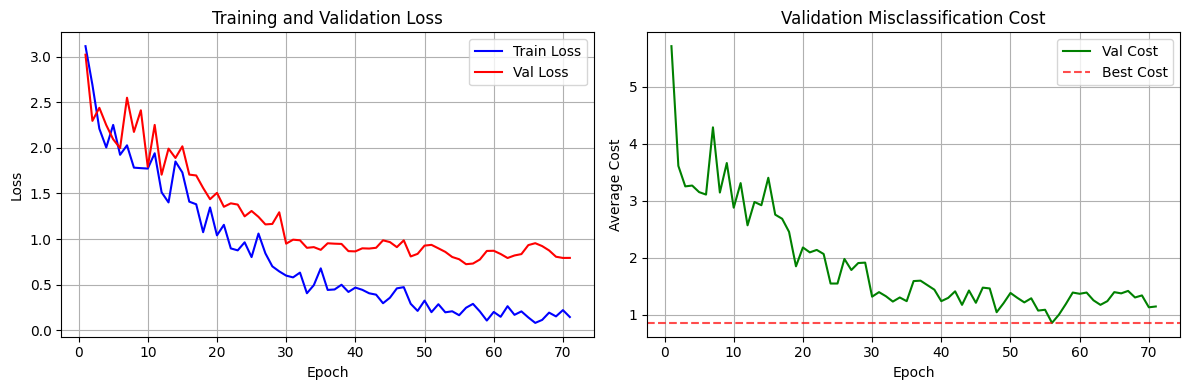

Best Validation Cost: 0.8561


In [102]:
fig = plot_cost_training_history(history_cost)
plt.show()

print(f"Best Validation Cost: {history_cost['best_val_cost']:.4f}")

### Evaluate cost-sensitive model

In [61]:
checkpoint_cost = torch.load(COST_CONFIG['MODEL_SAVE_PATH'], weights_only=False)
model_cost.load_state_dict(checkpoint_cost['model_state_dict'])
model_cost = model_cost.to(CONFIG['DEVICE'])
model_cost.eval()

print(f"Loaded best cost-sensitive model with validation cost: {checkpoint_cost['best_val_cost']:.4f}")
print(f"Model loaded on device: {CONFIG['DEVICE']}")

Loaded best cost-sensitive model with validation cost: 0.8561
Model loaded on device: cuda


#### Comprehensive Model Comparison

In [62]:
def compare_models(baseline_model, cost_model, test_loader, cost_matrix, device):
    baseline_cost, y_true_base, y_pred_base = evaluate_with_cost(baseline_model, test_loader, cost_matrix, device)
    cost_sensitive_cost, y_true_cs, y_pred_cs = evaluate_with_cost(cost_model, test_loader, cost_matrix, device)
    
    baseline_metrics = calculate_metrics(y_true_base, y_pred_base)
    cost_metrics = calculate_metrics(y_true_cs, y_pred_cs)
    
    comparison = {
        'Model': ['Baseline', 'Cost-Sensitive'],
        'Average Cost': [baseline_cost, cost_sensitive_cost],
        'Accuracy': [baseline_metrics['overall']['accuracy'] * 100, cost_metrics['overall']['accuracy'] * 100],
        'F1-Score': [baseline_metrics['overall']['f1_macro'], cost_metrics['overall']['f1_macro']],
        'Cost Reduction': ['-', f"{((baseline_cost - cost_sensitive_cost) / baseline_cost * 100):.2f}%"]
    }
    
    comparison_df = pd.DataFrame(comparison)
    
    return comparison_df, y_true_base, y_pred_base, y_true_cs, y_pred_cs

In [63]:
comparison_df, y_true_base, y_pred_base, y_true_cs, y_pred_cs = compare_models(
    model, model_cost, test_loader, COST_MATRIX, CONFIG['DEVICE']
)

print("=== Model Comparison ===")
print(comparison_df.to_string(index=False))

=== Model Comparison ===
         Model  Average Cost  Accuracy  F1-Score Cost Reduction
      Baseline      0.985612 86.330935  0.856165              -
Cost-Sensitive      0.856115 84.172662  0.841411         13.14%


#### Per-Class Cost Analysis

In [106]:
def analyze_per_class_cost(y_true, y_pred, cost_matrix):
    per_class_costs = []
    
    for class_idx in range(len(TARGET_CLASSES)):
        class_mask = y_true == class_idx
        if class_mask.sum() > 0:
            class_true = y_true[class_mask]
            class_pred = y_pred[class_mask]
            class_cost = calculate_misclassification_cost(class_true, class_pred, cost_matrix)
            per_class_costs.append(class_cost)
        else:
            per_class_costs.append(0.0)
    
    cost_df = pd.DataFrame({
        'Class': TARGET_CLASSES,
        'Baseline Cost': analyze_per_class_cost(y_true_base, y_pred_base, COST_MATRIX),
        'Cost-Sensitive Cost': per_class_costs
    })
    
    return cost_df

In [107]:
per_class_comparison = pd.DataFrame({
    'Class': TARGET_CLASSES,
    'Baseline Cost': [calculate_misclassification_cost(
        y_true_base[y_true_base == i], 
        y_pred_base[y_true_base == i], 
        COST_MATRIX
    ) if (y_true_base == i).sum() > 0 else 0.0 for i in range(5)],
    'Cost-Sensitive Cost': [calculate_misclassification_cost(
        y_true_cs[y_true_cs == i], 
        y_pred_cs[y_true_cs == i], 
        COST_MATRIX
    ) if (y_true_cs == i).sum() > 0 else 0.0 for i in range(5)]
})

print("\n=== Per-Class Cost Analysis ===")
print(per_class_comparison.to_string(index=False))


=== Per-Class Cost Analysis ===
                 Class  Baseline Cost  Cost-Sensitive Cost
Black_footed_Albatross       0.400000             1.400000
   Red_faced_Cormorant       1.545455             1.227273
              Bobolink       1.433333             0.400000
        Lazuli_Bunting       0.071429             0.678571
  Yellow_breasted_Chat       1.241379             0.655172


### Part 2 Results Analysis

### Modifications Made:
Implemented a hybrid cost-sensitive loss function that combines weighted cross-entropy loss with expected misclassification cost:

1. **Class Weights Calculation**: Computed class weights from the cost matrix by averaging misclassification costs per class

2. **Hybrid Loss Function**: Combined cross-entropy loss (70%) with expected cost loss (30%):
   - Cross-entropy ensures stable gradient flow and maintains accuracy
   - Expected cost term guides the model to minimize misclassification penalties
   
3. **Training Strategy**: Selected best model based on validation misclassification cost rather than accuracy

### Cost Comparison:

- **Original Model Average Cost**: 0.9856
- **Cost-Sensitive Model Average Cost**: 0.8561
- **Improvement**: 13.14% reduction
- **Accuracy Trade-off**: 86.33% -> 84.17% (-2.16%)

### Results Analysis:

The cost-sensitive approach reduced average misclassification cost by 13.14% with only a 2.16% accuracy decrease. This demonstrates effective cost-aware learning.

**Per-class improvements:**
- Bobolink: 66% cost reduction (1.433 -> 0.400)
- Yellow_breasted_Chat: 47% cost reduction (1.241 -> 0.655)
- Red_faced_Cormorant: 21% cost reduction (1.545 -> 1.227)

**Performance trade-offs:**
- Lazuli_Bunting and Black_footed_Albatross showed increased costs, suggesting the model prioritized reducing high-cost errors over low-cost ones.

## Part 3: Model Deployment for Competition [20 marks]

### Requirements:
- Create a `test_single` function that takes image file path as input
- Return single integer (0-4) corresponding to predicted class
- Must be in a standalone cell
- Ranking based on average misclassification cost on hidden test set

In [ ]:
# Prepare final model for deployment
# Load the best cost-sensitive model


## Final Deployment Function
**Note**: This cell contains the standalone `test_single` function for competition evaluation.

In [ ]:
# STANDALONE DEPLOYMENT FUNCTION - DO NOT MODIFY THIS CELL STRUCTURE

def test_single(image_path):
    """
    Test function for single image prediction

    Args:
        image_path (str): Path to the image file (e.g., 'img_test.jpg')

    Returns:
        int: Predicted class (0: Albatross, 1: Cormorant, 2: Bobolink, 3: Bunting, 4: Chat)
    """

    # Implementation here
    # 1. Load and preprocess the image
    # 2. Run inference with the trained model
    # 3. Return predicted class as integer

    pass

# Test the function
# test_result = test_single('path/to/test/image.jpg')
# print(f"Predicted class: {test_result}")

## Function Testing and Validation

In [ ]:
# Test the deployment function with sample images


---
# Final Summary and Submission Checklist

## Part 1 Deliverables ✓
- [ ] Clear model architecture description
- [ ] Performance table with all metrics
- [ ] Reproducible code with seeds set

## Part 2 Deliverables ✓
- [ ] Description of modifications for cost-sensitive learning
- [ ] Average misclassification cost results
- [ ] Improvement analysis and discussion

## Part 3 Deliverables ✓
- [ ] Standalone `test_single` function
- [ ] Function returns integer (0-4)
- [ ] Function accepts file path as input
- [ ] Error-free execution

## Technical Requirements ✓
- [ ] All training outputs retained
- [ ] Jupyter notebook with all artifacts
- [ ] Reproducible with same .ipynb file
- [ ] Random seeds set for reproducibility

---
**Assignment completed. Ready for submission.**